In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pyBigWig as bw
from scipy.stats import beta
import re
import os
import time
import multiprocessing as mp

ncols = 5
nrows = 3

gtf = '../resources/genome/GRCm39/gene_protein_coding.gtf'
circadian_core_genes = pd.read_csv(gtf, sep='\t', header=None)
circadian_core_genes.columns = ['chr', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute']

# Function to extract gene_name
def extract_attribute(entry,attribute):
    match = re.search(rf'{attribute} "([^"]+)"', entry)
    if match:
        return match.group(1)
    else:
        return None
    
circadian_core_genes['gene_name'] = circadian_core_genes['attribute'].apply(extract_attribute,attribute='gene_name')
circadian_core_genes['gene_id'] = circadian_core_genes['attribute'].apply(extract_attribute,attribute='gene_id')
circadian_core_genes.drop('attribute',axis=1,inplace=True)
# set gene name as index
circadian_core_genes.set_index('gene_name',inplace=True)

# keep only circadian core genes
my_genes = pd.read_csv('../resources/core_circadian_clock_genes_short.txt',sep='\t',usecols=[0])
my_genes = my_genes.mm10.values
circadian_core_genes = circadian_core_genes.loc[my_genes]
#idx = circadian_core_genes.gene_name.isin(my_genes)
#circadian_core_genes = circadian_core_genes[idx]
#circadian_core_genes.set_index('gene_name',inplace=True)
#circadian_core_genes.sort_index(inplace=True)

Phase_amp = {}

def FourierTransform(x,T,ω):

    N = T.shape[0]
    f_n = np.sum(x*np.exp(-1j*ω*T),1)
    a_n = 4/N * np.abs(f_n)
    φ_n = -np.arctan2(np.imag(f_n),np.real(f_n))
    μ = 1/N * np.sum(x,1)

    x_hat = μ[:,None] + 0.5 * a_n[:,None] * np.cos(ω * T[None,:] - φ_n[:,None])
    sig2_res = np.var(x - x_hat,1)
    sig2_tot = np.var(x,1)
    R2 = np.zeros(sig2_res.shape)
    R2[sig2_tot==0] = 0
    R2[sig2_tot!=0] = 1 - sig2_res[sig2_tot!=0] / sig2_tot[sig2_tot!=0]
    p = 3
    pval = 1 - beta.cdf(R2, (p - 1) / 2, (N - p) / 2)
    φ_n[φ_n<0] += np.pi * 2

    return φ_n, a_n, R2, pval, μ

### RNA-seq

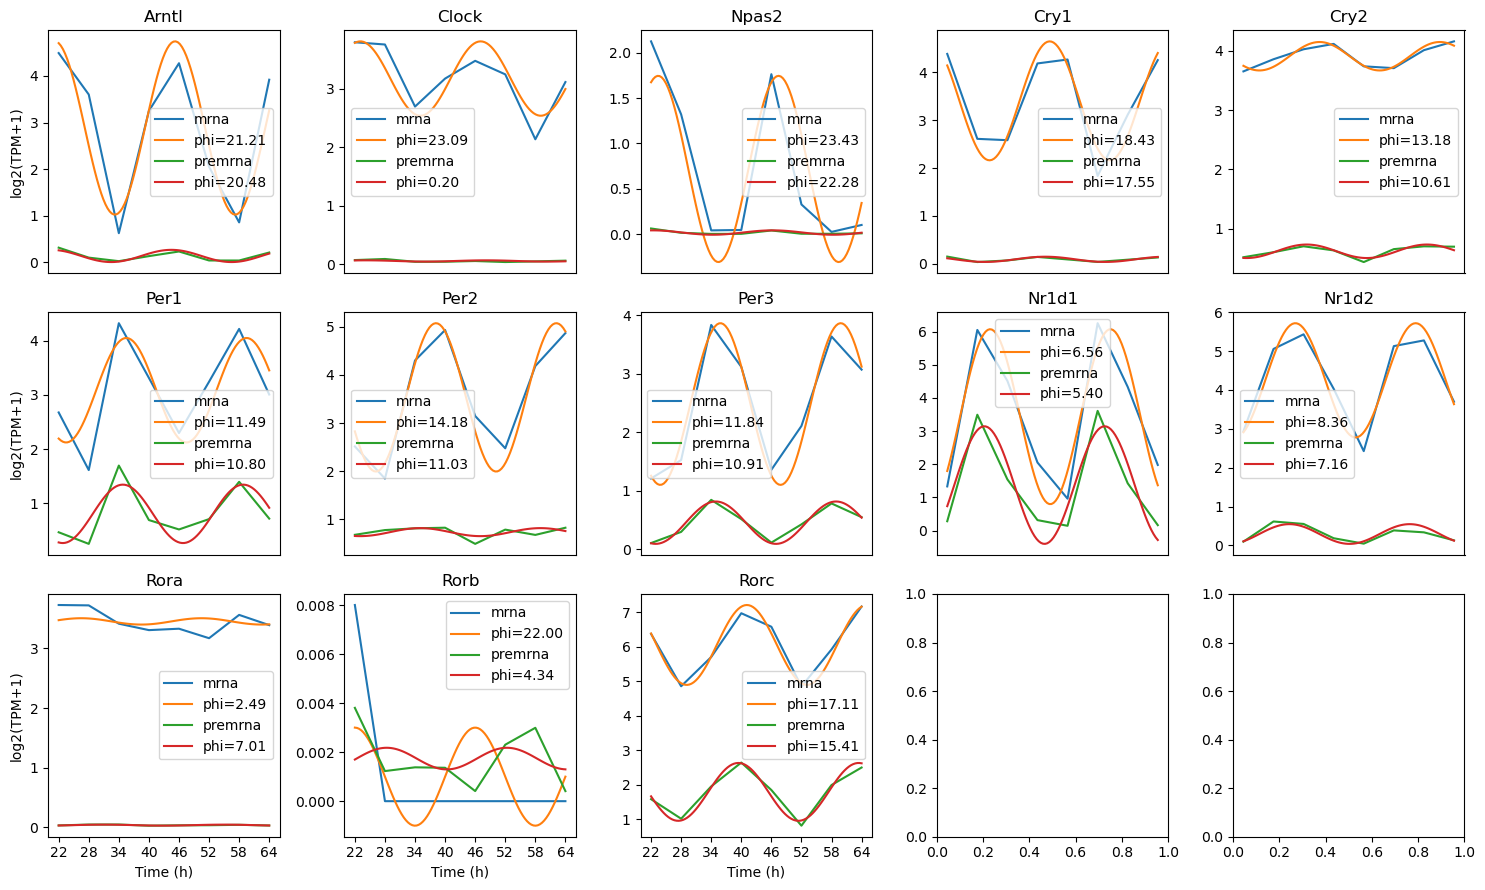

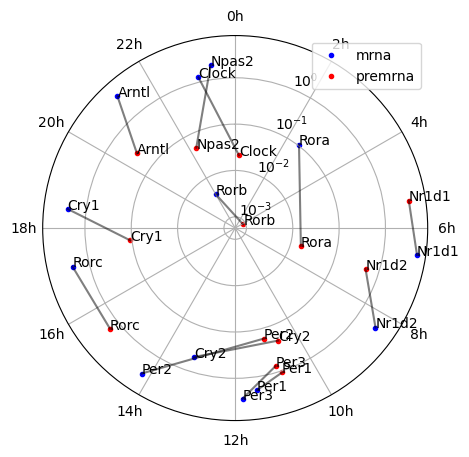

In [2]:
# Load rna-seq data
rnaseq = {}
T = np.arange(22,65,6)
cols = [f'Liv_CT{t}' for t in T]
for i in ['mrna','premrna']:
    rnaseq[i] = pd.read_csv(f'../../RNAseq/results/Zhang_PNAS_2014/kallisto/{i}_tpm_table.tab', sep='\t', index_col=0)

    # Keep only Liver samples
    rnaseq[i] = rnaseq[i].loc[:,cols]

# Keep only circadian core genes
gene_id = np.array([id.split('|')[1] for id in rnaseq['mrna'].index])
rnaseq['mrna'].loc[:,'gene_id'] = gene_id
rnaseq['premrna'].loc[:,'gene_id'] = gene_id

[idx_circadian_core_genes,idx_rnaseq] =  np.where(circadian_core_genes.gene_id.values[:,None] == gene_id[None,:])
for i in ['mrna','premrna']:
    rnaseq[i] = rnaseq[i].iloc[idx_rnaseq]
    # sum all row with same gene index and take the log
    rnaseq[i] = rnaseq[i].groupby(rnaseq[i].gene_id).sum().apply(lambda x: np.log2(x+1))
    # rearange
    rnaseq[i] = rnaseq[i].loc[circadian_core_genes.gene_id,:]
    rnaseq[i].index = circadian_core_genes.index

# fourier transform
N = rnaseq['mrna'].shape[1]
T = np.arange(22,65,6)
P = 24
n = 1
ω_n = 2*np.pi*n/P

for i in ['mrna','premrna']:

    Phase_amp[i] = pd.DataFrame( np.zeros((circadian_core_genes.shape[0],5)), columns=['phase','amplitude','R2','pval','mean_log_expression'])
    Phase_amp[i].index = circadian_core_genes.index

    x = rnaseq[i].values
    φ_n, a_n, R2, pval, mu = FourierTransform(x,T,ω_n)

    # make table
    Phase_amp[i].loc[:,'phase'] = φ_n
    Phase_amp[i].loc[:,'amplitude'] = a_n
    Phase_amp[i].loc[:,'R2'] = R2
    Phase_amp[i].loc[:,'pval'] = pval
    Phase_amp[i].loc[:,'mean_log_expression'] = mu


# plot all phase and amplitude in a polar plot
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*3,nrows*3))

t_ = np.linspace(22,64,100,endpoint=True)

for f in range(circadian_core_genes.shape[0]):
    ax = axes[f//ncols,f%ncols]
    g = circadian_core_genes.index[f]
    for i in ['mrna','premrna']:
        ax.plot(T,rnaseq[i].loc[g],label=i)
        # plot harmonic fit
        [mu, a_n, φ_n] = Phase_amp[i].loc[g,['mean_log_expression','amplitude','phase']]
        f_ = mu + 0.5 * a_n * np.cos(ω_n * t_ - φ_n)
        ax.plot(t_,f_, label=f'phi={φ_n/ω_n :.2f}')

    if f//ncols == nrows-1:
        ax.set_xlabel('Time (h)')
        ax.set_xticks(T)
    else:
        ax.set_xticks([])

    if f%ncols == 0:
        ax.set_ylabel('log2(TPM+1)')
    
    ax.legend()

    ax.set_title(g)

fig.tight_layout()


fig, ax = plt.subplots(figsize=(5,5),subplot_kw={'projection': 'polar'})
colors = {'mrna':'blue','premrna':'red'}
for i in ['mrna','premrna']:
    ax.scatter(Phase_amp[i].phase,Phase_amp[i].amplitude,label=i,color=colors[i],marker='.')
    # add names
    for g in Phase_amp[i].index:
        ax.text(Phase_amp[i].loc[g].phase,Phase_amp[i].loc[g].amplitude,g)

# connect same gene pre-mRNA and mRNA with thin line
for g in Phase_amp['mrna'].index:
    ax.plot([Phase_amp['mrna'].loc[g].phase,Phase_amp['premrna'].loc[g].phase], [Phase_amp['mrna'].loc[g].amplitude,Phase_amp['premrna'].loc[g].amplitude], color='black', alpha=0.5)

ax.set_xticks(np.linspace(0,2*np.pi,12,endpoint=False) )
ax.set_xticklabels([f'{t}h' for t in np.arange(0,24,2)])
ax.set_yticks([])
ax.set_theta_zero_location("N")  # theta=0 at the top
ax.set_theta_direction(-1)  # theta increasing clockwise
ax.set_yscale('log')
ax.legend()


# Plot mRNA

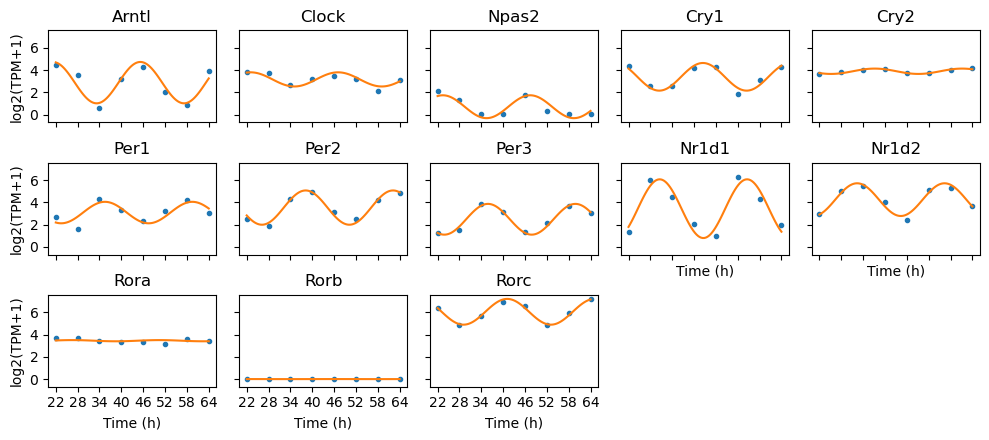

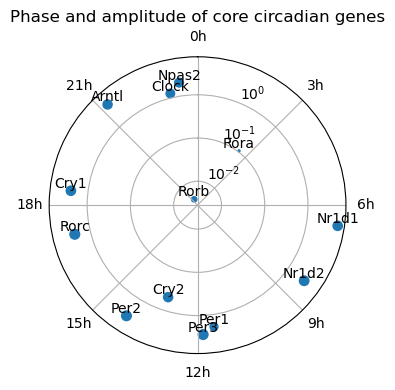

In [3]:
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*2,nrows*1.5),sharex=True,sharey=True)

t_ = np.linspace(22,64,100,endpoint=True)

for f,g in enumerate(circadian_core_genes.index):
    ax = axes[f//ncols,f%ncols]
    g = circadian_core_genes.index[f]
    i = 'mrna'
    ax.plot(T,rnaseq[i].loc[g],'.')

    # plot harmonic fit
    [mu, a_n, φ_n] = Phase_amp[i].loc[g,['mean_log_expression','amplitude','phase']]
    f_ = mu + 0.5 * a_n * np.cos(ω_n * t_ - φ_n)
    ax.plot(t_,f_)

    ax.set_xticks(T)
    if f >= (circadian_core_genes.shape[0] - ncols):
        ax.set_xlabel('Time (h)')
        ax.set_xticklabels(T)
    else:
        ax.set_xticklabels([])

    if f%ncols == 0:
        ax.set_ylabel('log2(TPM+1)')
        ax.set_yticks(np.arange(0,7,2))

    ax.set_title(g)

for f_empty in range(f+1,ncols*nrows):
    axes[f_empty//ncols,f_empty%ncols].axis('off')

fig.tight_layout()
fig.savefig('fig/mrna_proseq/mrna_harmonic_fit_core_circadian_genes.pdf')


fig, ax = plt.subplots(figsize=(4,4),subplot_kw={'projection': 'polar'})

i = 'mrna'
ax.scatter(Phase_amp[i].phase,Phase_amp[i].amplitude,s=50*Phase_amp[i].R2)
# add names
for g in Phase_amp[i].index:
    ax.text(Phase_amp[i].loc[g].phase,Phase_amp[i].loc[g].amplitude,g,ha='center',va='bottom')

tick = np.arange(0,24,3)
ax.set_xticks(tick/24*2*np.pi)
ax.set_xticklabels([f'{t}h' for t in tick])
ax.set_yticks([])
ax.set_theta_zero_location("N")  # theta=0 at the top
ax.set_theta_direction(-1)  # theta increasing clockwise
ax.set_yscale('log')
ax.set_title('Phase and amplitude of core circadian genes')

fig.tight_layout()
fig.savefig('fig/mrna_proseq/mrna_phase_amp_core_circadian_genes.pdf')

### PRO-seq

In [4]:
# get circadian core genes coordinates

Strands = ['forward', 'reverse']
strand_dict = {'forward':'+', 'reverse':'-', '+':'forward', '-':'reverse'}
T = np.arange(0,48,4)
Nt = len(T)
Samples = ['CT{:02d}'.format(t) for t in T]

# get pro-seq count tables
infolder = '../results/norm_coverage'

# output folder for genes bedgraph
outfold = 'genes_bedgraph'

def get_gene_by_coord(args):
    [chr,start,end,fin,fout] = args
    if not os.path.exists(fout):
        os.system(f'./get_gene_by_coord.sh {chr} {start} {end} {fin} {fout}')
    return 0

args = []
for g in circadian_core_genes.index:
    [chr,start,end,strand] = circadian_core_genes.loc[g,['chr','start','end','strand']]
    for t in T:
        sample = f'CT{t:02d}'
        fin = f'{infolder}/{sample}/NormCoverage_3p_{strand_dict[strand]}.bedgraph'
        fout = f'{outfold}/{g}_{sample}.bedgraph'
        args.append([chr,start,end,fin,fout])

# run in parralel
with mp.Pool(processes=48) as pool:
    out = pool.map(get_gene_by_coord,args)

proseq = {}
for g in circadian_core_genes.index:
    proseq[g] = pd.DataFrame(columns=['chr','start','end'])
    for t in T:
        sample = f'CT{t:02d}'
        fin = f'{outfold}/{g}_{sample}.bedgraph'

        df_t = pd.read_csv(fin,sep='\t',header=None)
        df_t.columns = ['chr','start','end',sample]

        proseq[g] = pd.merge(proseq[g],df_t,on=['chr','start','end'],how='outer')
    proseq[g].set_index('start',inplace=True)
    proseq[g] = proseq[g].loc[:,Samples]


# sum counts in gene body
samples = [f'CT{t:02d}' for t in T]
tpm = pd.DataFrame(np.zeros((len(proseq),len(samples))))
tpm.columns = samples
tpm.index = proseq.keys()
log_tpm = pd.DataFrame(np.zeros((len(proseq),len(samples))))
for g in proseq:
    tpm.loc[g] = proseq[g].fillna(0).sum(0)
    log_tpm = np.log2(tpm+1)

Phase_amp['proseq_logtpm'] = pd.DataFrame( np.zeros((len(proseq),5)), columns=['phase','amplitude','R2','pval','mean_log_expression'])
Phase_amp['proseq_logtpm'].index = circadian_core_genes.index

# Fourrier transform
T = np.arange(0,48,4)
P = 24
n = 1
ω_n = 2*np.pi*n/P
x = log_tpm.values
φ_n, a_n, R2, pval, mu = FourierTransform(x,T,ω_n)

# make table
Phase_amp['proseq_logtpm'].loc[:,'phase'] = φ_n
Phase_amp['proseq_logtpm'].loc[:,'amplitude'] = a_n
Phase_amp['proseq_logtpm'].loc[:,'R2'] = R2
Phase_amp['proseq_logtpm'].loc[:,'pval'] = pval
Phase_amp['proseq_logtpm'].loc[:,'mean_log_expression'] = mu


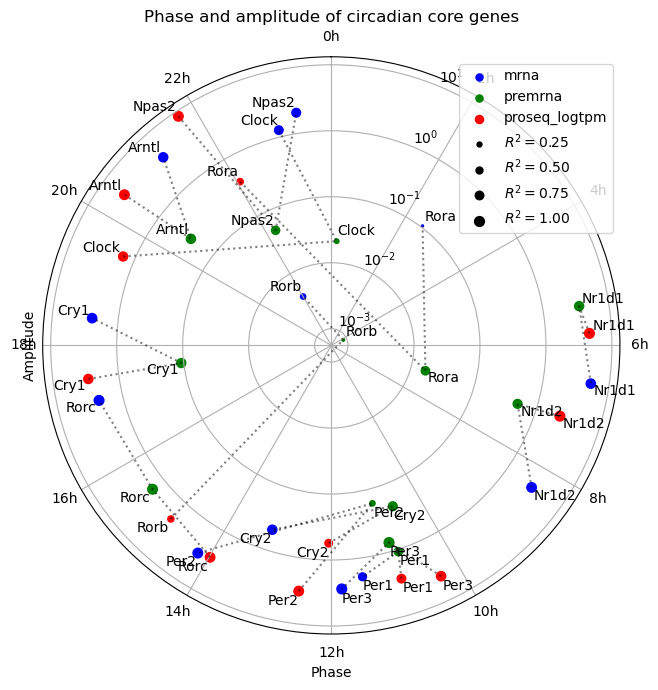

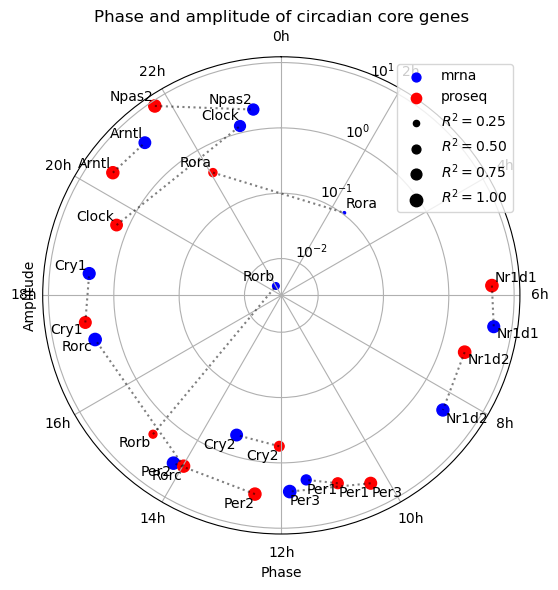

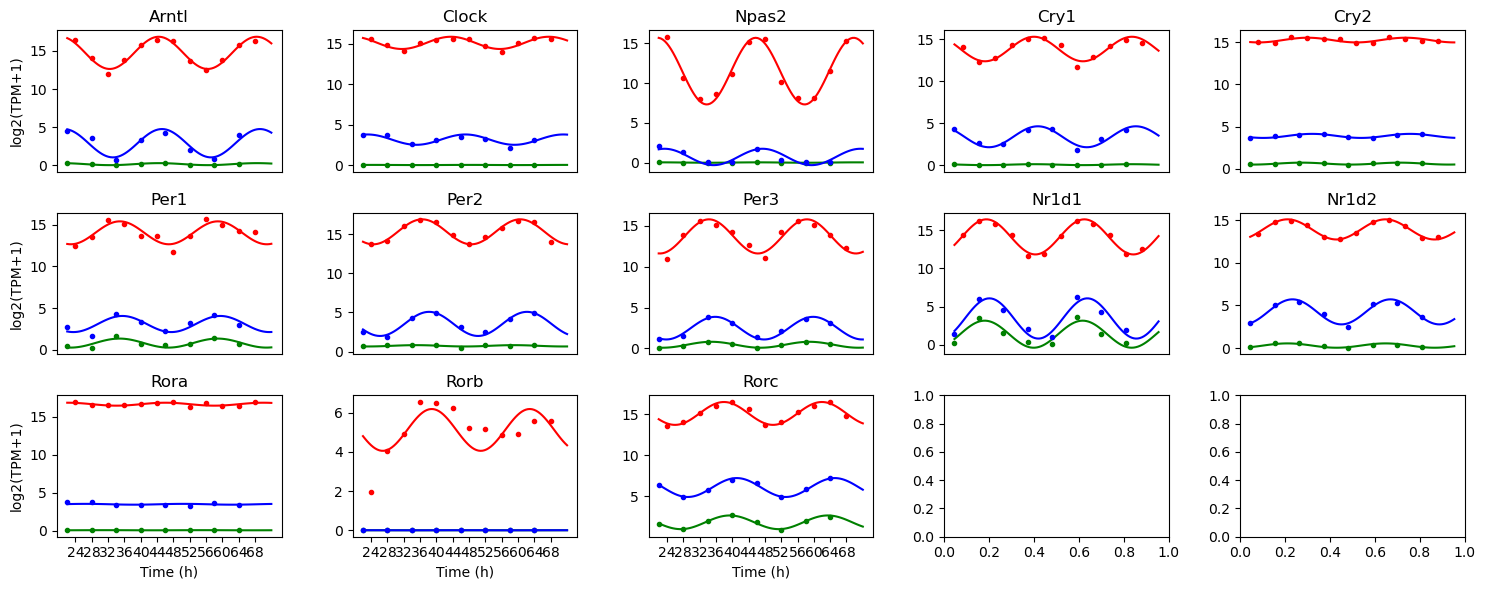

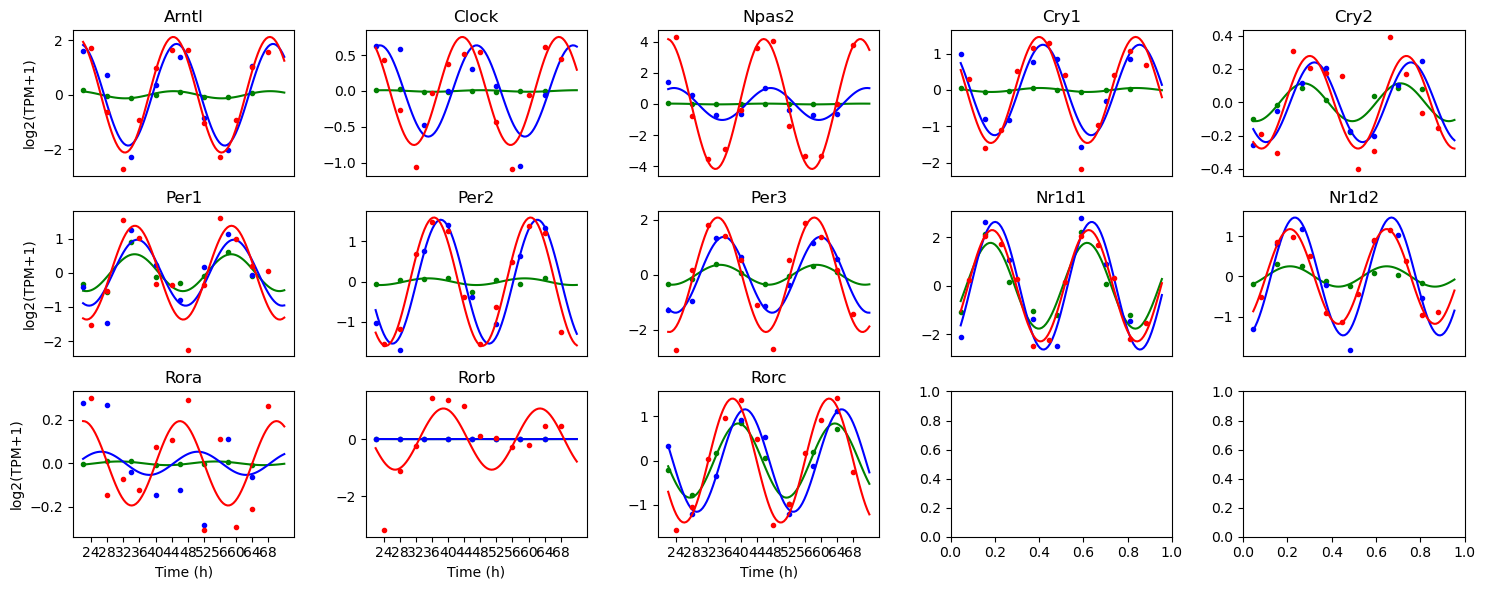

In [15]:


fig, ax = plt.subplots(figsize=(7,7),subplot_kw={'projection': 'polar'})

# connect same gene proseq log_tpm to pre-mRNA to mRNA with thin line
for g in circadian_core_genes.index:
    ax.plot([Phase_amp['proseq_logtpm'].loc[g].phase,Phase_amp['premrna'].loc[g].phase,Phase_amp['mrna'].loc[g].phase], [Phase_amp['proseq_logtpm'].loc[g].amplitude,Phase_amp['premrna'].loc[g].amplitude,Phase_amp['mrna'].loc[g].amplitude], color='black', alpha=0.5,linestyle=':')
colors = {'mrna':'blue','premrna':'green','proseq_logtpm':'red'}
for i in ['mrna','premrna','proseq_logtpm']:
    ax.scatter(Phase_amp[i].phase,Phase_amp[i].amplitude,s=Phase_amp[i].R2*50,label=i,color=colors[i],marker='o')
    # add names
    for g in Phase_amp[i].index:
        if Phase_amp[i].loc[g].phase < np.pi:
            ha='left'
        else:
            ha='right'
        if (Phase_amp[i].loc[g].phase < np.pi/2) or (Phase_amp[i].loc[g].phase > 3*np.pi/2):
            va='bottom'
        else:
            va='top'
        ax.text(Phase_amp[i].loc[g].phase,1.1*Phase_amp[i].loc[g].amplitude,g,ha=ha,va=va)

    
ax.set_xticks(np.linspace(0,2*np.pi,12,endpoint=False) )
ax.set_xticklabels([f'{t}h' for t in np.arange(0,24,2)])
ax.set_yticks([])
ax.set_theta_zero_location("N")  # theta=0 at the top
ax.set_theta_direction(-1)  # theta increasing clockwise
ax.set_yscale('log')

ax.set_title('Phase and amplitude of circadian core genes')
ax.set_xlabel('Phase')
ax.set_ylabel('Amplitude')


# Make legend to show the color of the different lines and the size corresponding to R2 and put it outside
#for i in colors:
#    ax.scatter([],[],s=50,label=i,color=colors[i],marker='o')
for r2 in [0.25,0.5,0.75,1]:
    ax.scatter([],[],s=r2*50,label=fr'$R^2={r2:.2f}$',color='black',marker='o')
ax.legend(loc='upper right')

fig.tight_layout()
fig.savefig('fig/mrna_proseq/circadian_core_genes_phase_amplitude_mrna_premrna_proseq.pdf')




fig, ax = plt.subplots(figsize=(6,6),subplot_kw={'projection': 'polar'})

# connect same gene proseq log_tpm to pre-mRNA to mRNA with thin line
for g in circadian_core_genes.index:
    ax.plot([Phase_amp['proseq_logtpm'].loc[g].phase,Phase_amp['mrna'].loc[g].phase], [Phase_amp['proseq_logtpm'].loc[g].amplitude,Phase_amp['mrna'].loc[g].amplitude], color='black', alpha=0.5,linestyle=':')
colors = {'mrna':'blue','premrna':'green','proseq_logtpm':'red'}
for i in ['mrna','proseq_logtpm']:
    ax.scatter(Phase_amp[i].phase,Phase_amp[i].amplitude,s=Phase_amp[i].R2*80,label=i.replace('_logtpm',''),color=colors[i],marker='o')
    # add names
    for g in Phase_amp[i].index:
        if Phase_amp[i].loc[g].phase < np.pi:
            ha='left'
        else:
            ha='right'
        if (Phase_amp[i].loc[g].phase < np.pi/2) or (Phase_amp[i].loc[g].phase > 3*np.pi/2):
            va='bottom'
        else:
            va='top'
        ax.text(Phase_amp[i].loc[g].phase,1.1*Phase_amp[i].loc[g].amplitude,g,ha=ha,va=va)

    
ax.set_xticks(np.linspace(0,2*np.pi,12,endpoint=False) )
ax.set_xticklabels([f'{t}h' for t in np.arange(0,24,2)])
ax.set_yticks([])
ax.set_theta_zero_location("N")  # theta=0 at the top
ax.set_theta_direction(-1)  # theta increasing clockwise
ax.set_yscale('log')

ax.set_title('Phase and amplitude of circadian core genes')
ax.set_xlabel('Phase')
ax.set_ylabel('Amplitude')

for r2 in [0.25,0.5,0.75,1]:
    ax.scatter([],[],s=r2*80,label=fr'$R^2={r2:.2f}$',color='black',marker='o')
ax.legend(loc='upper right')#,fontsize=6)

fig.tight_layout()
fig.savefig('fig/mrna_proseq/circadian_core_genes_phase_amplitude_mrna_proseq.pdf')





# plot all phase and amplitude in a polar plot
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*3,nrows*2))

t_ = np.linspace(22,72,100,endpoint=True)

for f in range(circadian_core_genes.shape[0]):
    ax = axes[f//ncols,f%ncols]
    g = circadian_core_genes.index[f]
    for i in ['premrna','mrna']:
        T_ = np.arange(22,65,6)
        ax.plot(T_,rnaseq[i].loc[g],'.',label=i,color=colors[i])
        # plot harmonic fit
        [mu, a_n, φ_n] = Phase_amp[i].loc[g,['mean_log_expression','amplitude','phase']]
        f_ = mu + 0.5 * a_n * np.cos(ω_n * t_ - φ_n)
        ax.plot(t_,f_, label=f'phi={φ_n/ω_n :.2f}',color=colors[i])

    i = 'proseq_logtpm'
    T_ = np.arange(0,48,4) + 24
    ax.plot(T_,log_tpm.loc[g],'.',label=i,color=colors[i])
    # plot harmonic fit
    [mu, a_n, φ_n] = Phase_amp[i].loc[g,['mean_log_expression','amplitude','phase']]
    f_ = mu + 0.5 * a_n * np.cos(ω_n * t_ - φ_n)
    ax.plot(t_,f_, label=f'phi={φ_n/ω_n :.2f}',color=colors[i])

    if f//ncols == nrows-1:
        ax.set_xlabel('Time (h)')
        ax.set_xticks(np.arange(0,48,4)+24)
    else:
        ax.set_xticks([])

    if f%ncols == 0:
        ax.set_ylabel('log2(TPM+1)')
    
    ax.set_title(g)
fig.tight_layout()


# plot all phase and amplitude in a polar plot centered on the mean expression
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*3,nrows*2))

for f in range(circadian_core_genes.shape[0]):
    ax = axes[f//ncols,f%ncols]
    g = circadian_core_genes.index[f]
    for i in ['premrna','mrna']:
        T_ = np.arange(22,65,6)
        ax.plot(T_,rnaseq[i].loc[g] - rnaseq[i].loc[g].mean(),'.',label=i,color=colors[i])
        # plot harmonic fit
        [mu, a_n, φ_n] = Phase_amp[i].loc[g,['mean_log_expression','amplitude','phase']]
        f_ = 0.5 * a_n * np.cos(ω_n * t_ - φ_n)
        ax.plot(t_,f_, label=f'phi={φ_n/ω_n :.2f}',color=colors[i])

    i = 'proseq_logtpm'
    T_ = np.arange(0,48,4) + 24
    ax.plot(T_,log_tpm.loc[g] - log_tpm.loc[g].mean(),'.',label=i,color=colors[i])
    # plot harmonic fit
    [mu, a_n, φ_n] = Phase_amp[i].loc[g,['mean_log_expression','amplitude','phase']]
    f_ = 0.5 * a_n * np.cos(ω_n * t_ - φ_n)
    ax.plot(t_,f_, label=f'phi={φ_n/ω_n :.2f}',color=colors[i])

    if f//ncols == nrows-1:
        ax.set_xlabel('Time (h)')
        ax.set_xticks(np.arange(0,48,4)+24)
    else:
        ax.set_xticks([])

    if f%ncols == 0:
        ax.set_ylabel('log2(TPM+1)')
    
    ax.set_title(g)
fig.tight_layout()

0
2
4
6
8
10
12


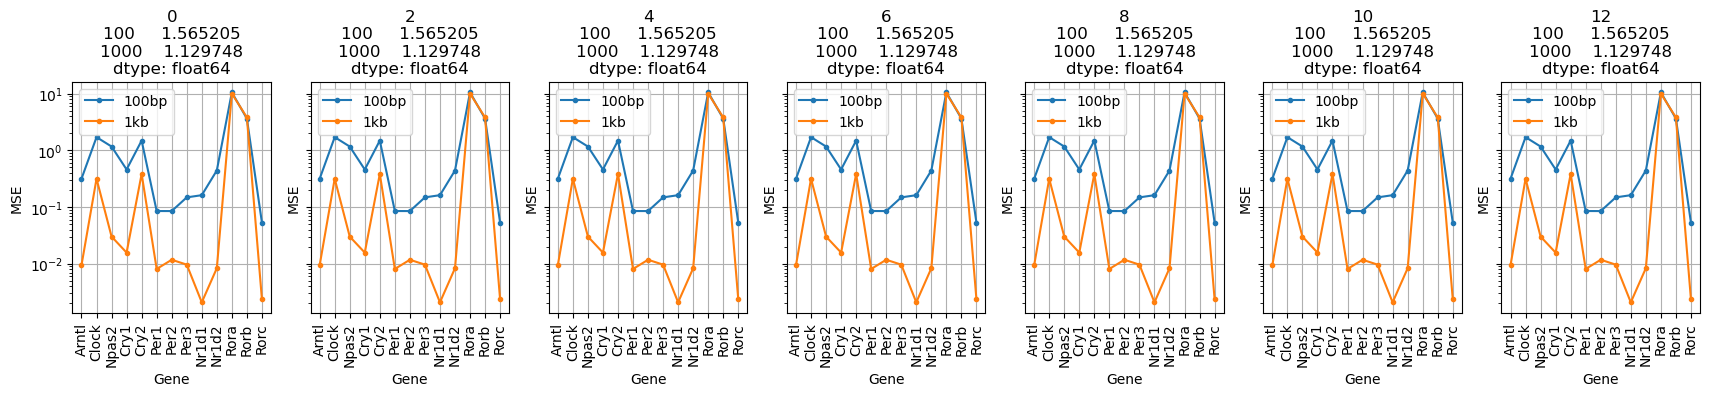

In [6]:
# sum counts in gene body
samples = [f'CT{t:02d}' for t in T]
tpm = pd.DataFrame(np.zeros((len(proseq),len(samples))))
tpm.columns = samples
tpm.index = proseq.keys()
log_tpm = pd.DataFrame(np.zeros((len(proseq),len(samples))))
for g in proseq:
    tpm.loc[g] = proseq[g].fillna(0).sum(0)
    log_tpm = np.log2(tpm+1)

Phase_amp['proseq_logtpm'] = pd.DataFrame( np.zeros((len(proseq),5)), columns=['phase','amplitude','R2','pval','mean_log_expression'])
Phase_amp['proseq_logtpm'].index = circadian_core_genes.index

# Fourrier transform
T = np.arange(0,48,4)
N = len(T)
P = 24
n = 1
ω_n = 2*np.pi*n/P
x = log_tpm.values
φ_n, a_n, R2, pval, mu = FourierTransform(x,T,ω_n)

# make table
Phase_amp['proseq_logtpm'].loc[:,'phase'] = φ_n
Phase_amp['proseq_logtpm'].loc[:,'amplitude'] = a_n
Phase_amp['proseq_logtpm'].loc[:,'R2'] = R2
Phase_amp['proseq_logtpm'].loc[:,'pval'] = pval
Phase_amp['proseq_logtpm'].loc[:,'mean_log_expression'] = mu

# get phase and amplitude of per bind
Bin_size = [100,1000]

frac_of_nan_max = np.arange(0,N+1,2)
MSE = {}
for f_nan in frac_of_nan_max:
    print(f_nan)
    binned_proseq = {}
    MSE[f_nan] = pd.DataFrame( np.zeros((len(circadian_core_genes),len(Bin_size))) )
    MSE[f_nan].index = circadian_core_genes.index
    MSE[f_nan].columns = Bin_size

    for bin_size in Bin_size:
        Phase_amp[f'proseq_logtpm_{bin_size}'] = {}
        binned_proseq[bin_size] = {}

        for g in circadian_core_genes.index:
            
            x = proseq[g]
            
            b0 = x.index[0] - x.index[0] % bin_size
            b1 = x.index[-1] - x.index[-1] % bin_size + bin_size
            bins = np.arange(b0,b1+1,bin_size)

            bin_idx = np.digitize(x.index,bins) - 1
            x = x.groupby(bin_idx).sum()
            my_index = []
            for i in range(len(x)):
                my_index.append(f'{bins[i]}-{bins[i+1]}')
            x.index = my_index

            # keep only bins with less than 2 thirds nan values (at least 4 time points with data)
            n = np.isnan( x.values ).sum()
            if n>0:
                print(f'{g} has {n} nan values')
            idx_in = np.isnan( x.values ).sum(1) <= f_nan
            x = x[idx_in]
            x = x.fillna(0)

            x = np.log2(x+1)
            binned_proseq[bin_size][g] = x
            
            
            φ_n, a_n, R2, pval, mu = FourierTransform(x.values,T,ω_n)

            # make table
            Phase_amp[f'proseq_logtpm_{bin_size}'][g] = pd.DataFrame( np.zeros((x.shape[0],5)), columns=['phase','amplitude','R2','pval','mean_log_expression'])
            Phase_amp[f'proseq_logtpm_{bin_size}'][g].index = x.index
            Phase_amp[f'proseq_logtpm_{bin_size}'][g].loc[:,'phase'] = φ_n
            Phase_amp[f'proseq_logtpm_{bin_size}'][g].loc[:,'amplitude'] = a_n
            Phase_amp[f'proseq_logtpm_{bin_size}'][g].loc[:,'R2'] = R2
            Phase_amp[f'proseq_logtpm_{bin_size}'][g].loc[:,'pval'] = pval
            Phase_amp[f'proseq_logtpm_{bin_size}'][g].loc[:,'mean_log_expression'] = mu

            MSE[f_nan].loc[g,bin_size] = np.mean( (φ_n - Phase_amp['proseq_logtpm'].loc[g,'phase'])**2 )


# Plot mean square difference between bin pases and gene phase
fig, axes = plt.subplots(1,7,figsize=(21,3),sharey=True)
for f_nan in frac_of_nan_max:
    ax = axes[f_nan//2]
    ax.plot(MSE[f_nan].loc[:,100],'.-')
    ax.plot(MSE[f_nan].loc[:,1000],'.-')
    ax.set_yscale('log') 
    ax.grid('on')
    ax.set_xlabel('Gene')
    ax.set_ylabel('MSE')
    ax.set_xticks(np.arange(len(MSE[f_nan])))
    ax.set_xticklabels(MSE[f_nan].index,rotation=90)
    ax.legend(['100bp','1kb'])
    ax.set_title(f'{f_nan}\n{MSE[f_nan].mean(0)}')





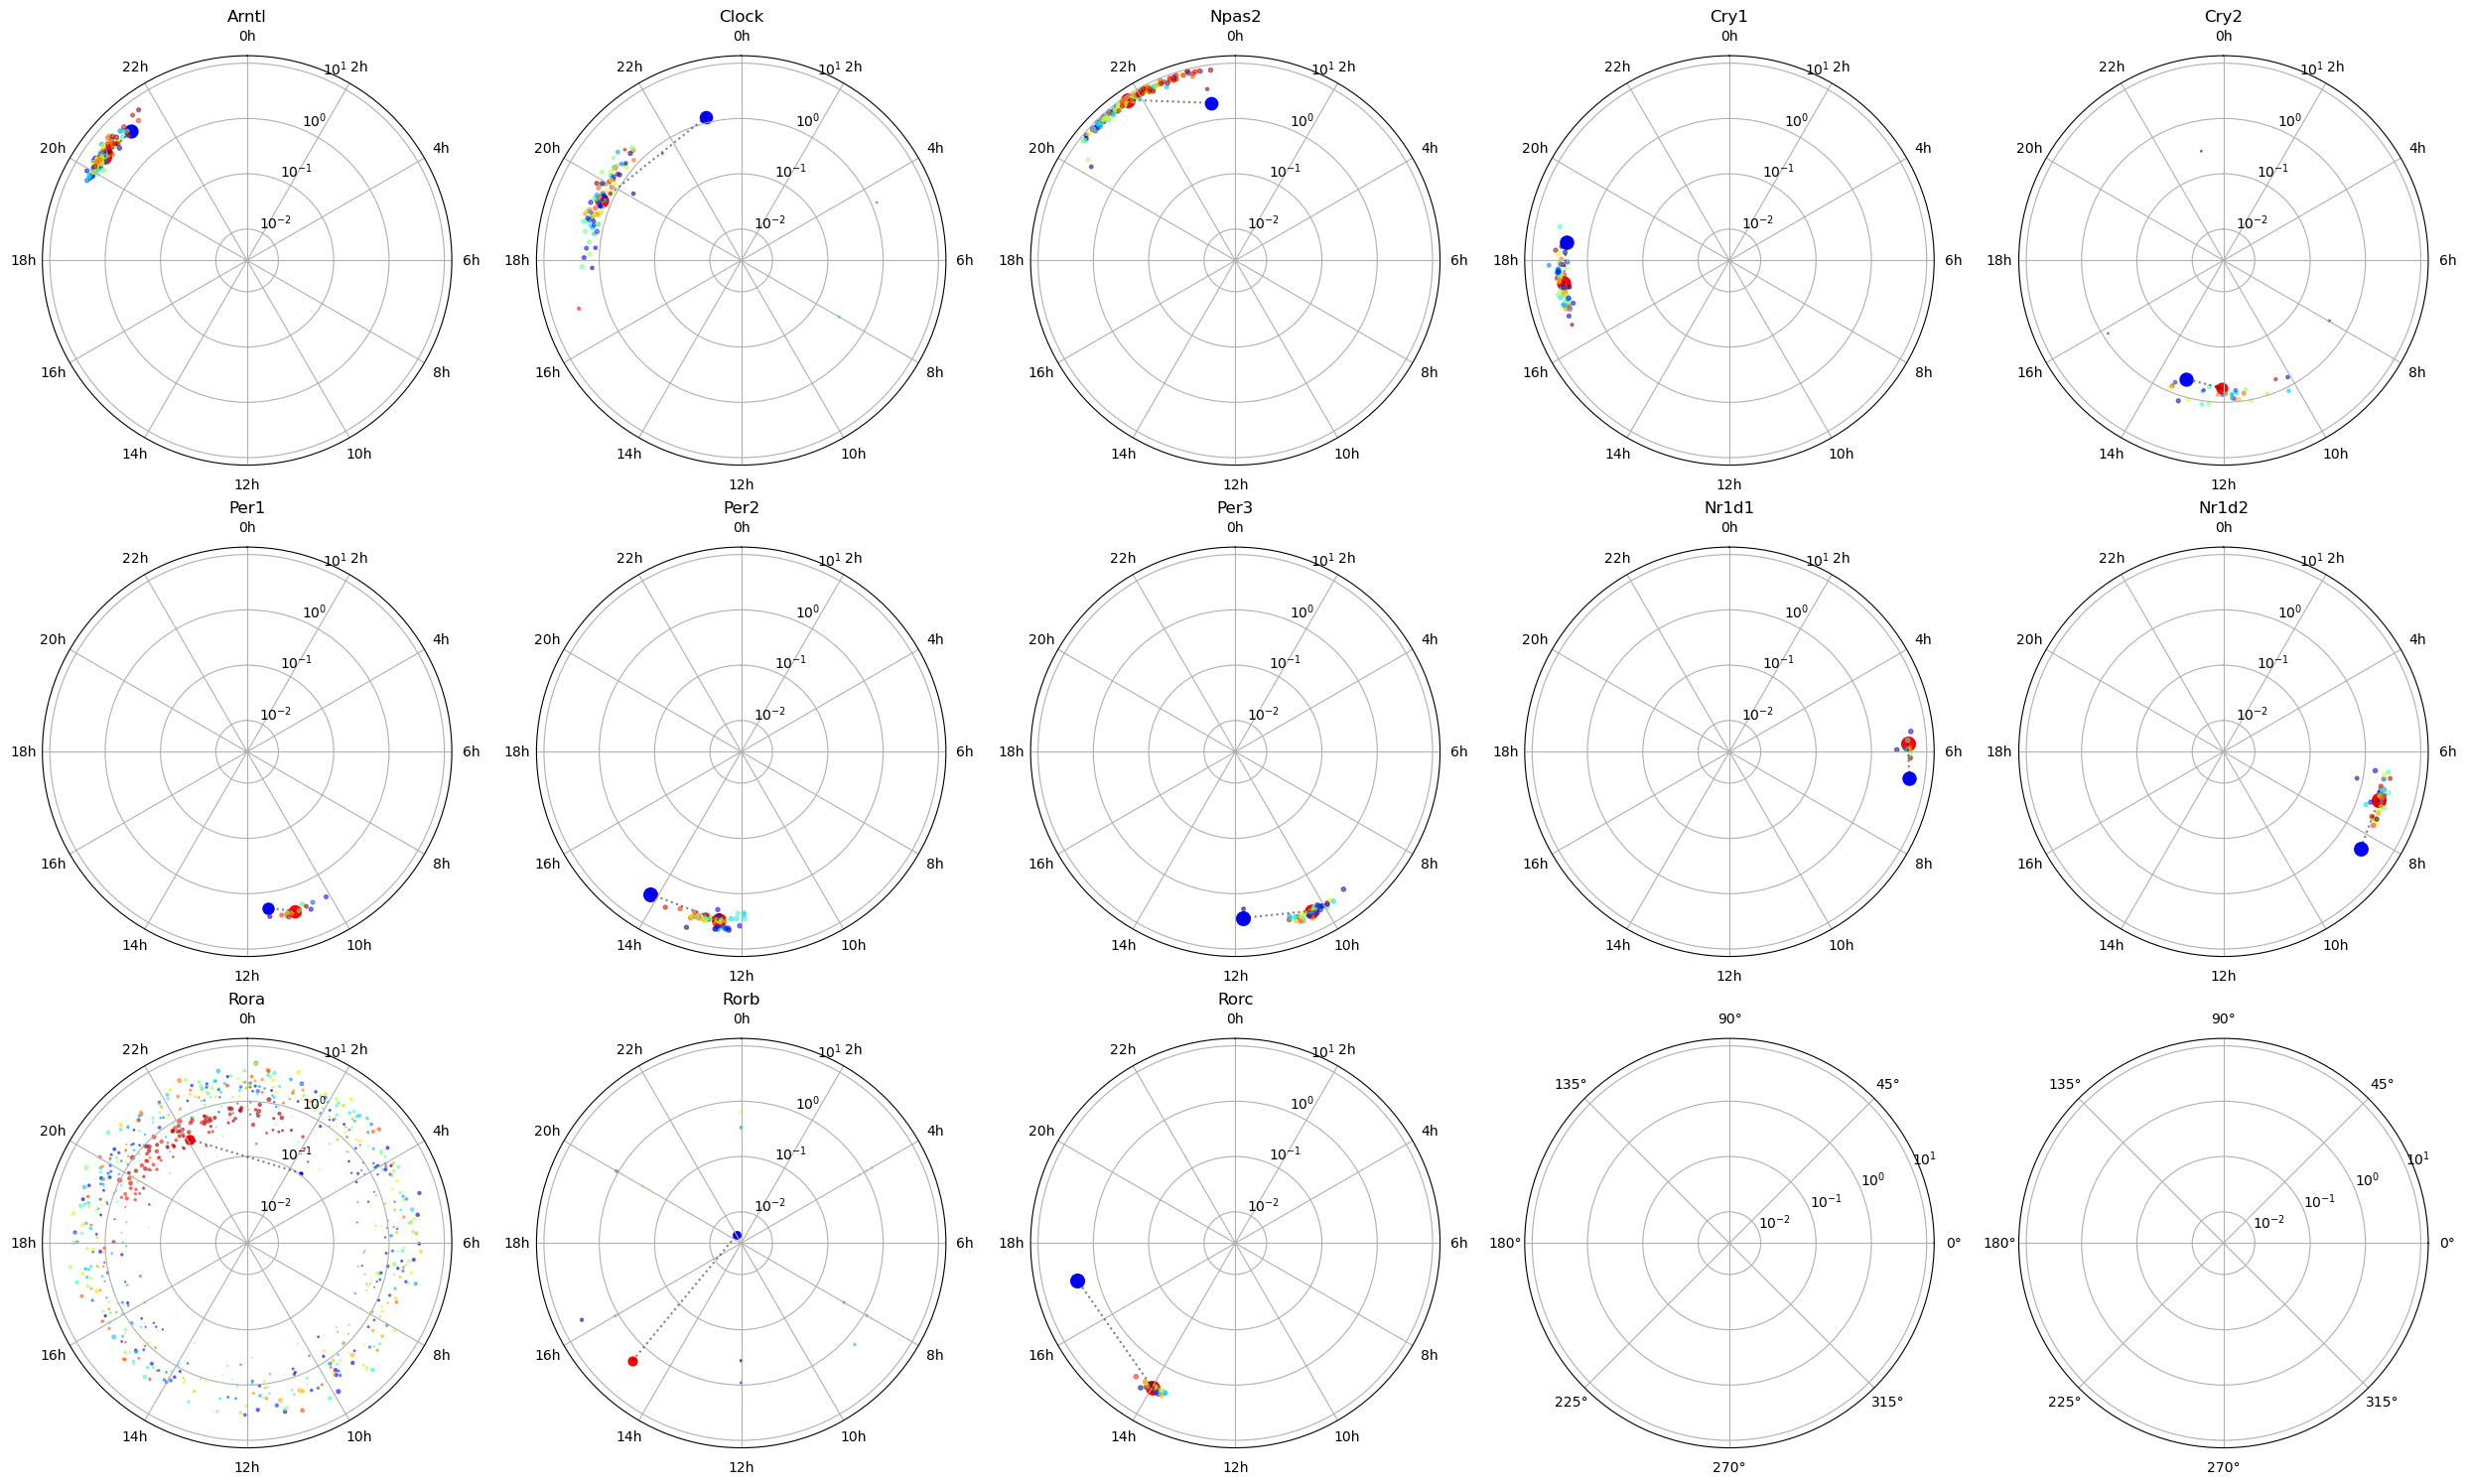

In [7]:

# plot all phase and amplitude in a polar plot
colors = {'mrna':'blue','premrna':'green','proseq_logtpm':'red'}
t_ = np.linspace(0,48,100,endpoint=True)        
bin_size = 1000


if False:
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*5,nrows*5))
    for f in range(circadian_core_genes.shape[0]):
        ax = axes[f//ncols,f%ncols]
        g = circadian_core_genes.index[f]
        i = 'proseq_logtpm'
        
        ax.plot(T,log_tpm.loc[g]-log_tpm.loc[g].mean(),'x')
        # plot harmonic fit
        [mu, a_n, φ_n] = Phase_amp[i].loc[g,['mean_log_expression','amplitude','phase']]
        f_ = 0.5 * a_n * np.cos(ω_n * t_ - φ_n)
        ax.plot(t_,f_, label=f'phi={φ_n/ω_n :.2f}')

        T_ = np.repeat(T[None,:],binned_proseq[bin_size][g].shape[0],0)
        y = binned_proseq[bin_size][g].values - binned_proseq[bin_size][g].values.mean(1)[:,None]
        ax.scatter(T_,y,marker='.',alpha=0.1,color='black')
        ax.plot(T,y.mean(0),'o')
        if f//ncols == nrows-1:
            ax.set_xlabel('Time (h)')
            ax.set_xticks(T)
        else:
            ax.set_xticks([])
        if f%ncols == 0:
            ax.set_ylabel('log2(TPM+1)')
        
        ax.set_title(g)
    fig.tight_layout()




# plot all phase and amplitude in a polar, shared y-axis
fig, axes = plt.subplots(ncols=ncols, nrows=nrows,figsize=(ncols*5,nrows*5),subplot_kw={'projection': 'polar'},sharey=True)
for f,g in enumerate(circadian_core_genes.index):
    ax = axes[f//ncols,f%ncols]

    # connect same gene proseq log_tpm to pre-mRNA to mRNA with thin line
    #ax.plot([Phase_amp['proseq_logtpm'].loc[g].phase,Phase_amp['premrna'].loc[g].phase,Phase_amp['mrna'].loc[g].phase], [Phase_amp['proseq_logtpm'].loc[g].amplitude,Phase_amp['premrna'].loc[g].amplitude,Phase_amp['mrna'].loc[g].amplitude], color='black', alpha=0.5,linestyle=':')
    ax.plot([Phase_amp['proseq_logtpm'].loc[g].phase,Phase_amp['mrna'].loc[g].phase], [Phase_amp['proseq_logtpm'].loc[g].amplitude,Phase_amp['mrna'].loc[g].amplitude], color='black', alpha=0.5,linestyle=':')
    # add gene phase amd and names
    for i in ['mrna','proseq_logtpm']:
        ax.scatter(Phase_amp[i].loc[g].phase,Phase_amp[i].loc[g].amplitude,s=Phase_amp[i].loc[g].R2*100,label=i,color=colors[i],marker='o')
        #ax.text(Phase_amp[i].loc[g].phase,Phase_amp[i].loc[g].amplitude,g)

    i = f'proseq_logtpm_{bin_size}'
    # color point from start to end
    pos = np.array( [np.array(i.split('-')).astype(int).mean() for i in binned_proseq[bin_size][g].index] )
    # bound in [0,1]
    pos = (pos - pos[0]) / (pos[-1] - pos[0])

    if circadian_core_genes.at[g,'strand'] == '-':
        pos = 1 - pos
    ax.scatter(Phase_amp[i][g].phase,Phase_amp[i][g].amplitude,s=Phase_amp[i][g].R2*10,label=i,c=pos,marker='o',alpha=0.5,cmap=cm.jet)
    # add names at the average position
    #ax.text(Phase_amp[i][g].phase.mean(),Phase_amp[i][g].amplitude.mean(),g,fontsize=6)
        
    ax.set_xticks(np.linspace(0,2*np.pi,12,endpoint=False) )
    ax.set_xticklabels([f'{t}h' for t in np.arange(0,24,2)])
    ax.set_yticks([])
    ax.set_theta_zero_location("N")  # theta=0 at the top
    ax.set_theta_direction(-1)  # theta increasing clockwise
    ax.set_yscale('log')
    #ax.set_ylim((0.002731409423451349, 12.259586654320987))

    ax.set_title(g)
fig.tight_layout()

fig.savefig('fig/mrna_proseq/circadian_core_genes_phase_amplitude_mrna_proseq_1000bp_bins.pdf')



# Phase distribution across all gene

(29139, 9)
(17599, 8)


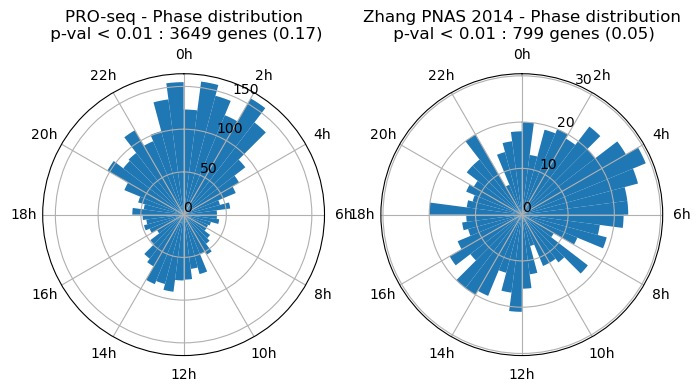

In [26]:
# proseq data
gene_phase_amp = pd.read_csv('../results/phase_amp/gene_phase_amp.csv',sep='\t')


# Load rna-seq data
T = np.arange(22,65,6)
cols = [f'Liv_CT{t}' for t in T]
rnaseq = pd.read_csv(f'../../RNAseq/results/Zhang_PNAS_2014/kallisto/mrna_tpm_table.tab', sep='\t', index_col=0)
# Keep only Liver samples
rnaseq = rnaseq.loc[:,cols]

gene_id = np.array([id.split('|')[1] for id in rnaseq.index])
rnaseq.loc[:,'gene_id'] = gene_id
print(rnaseq.shape)

# sum all row with same gene index and take the log
rnaseq = rnaseq.groupby(rnaseq.gene_id).sum().apply(lambda x: np.log2(x+1))

print(rnaseq.shape)

# fourier transform
N = rnaseq.shape[1]
T = np.arange(22,65,6)
P = 24
n = 1
ω_n = 2*np.pi*n/P

φ_n, a_n, R2, pval, mu = FourierTransform(rnaseq.values,T,ω_n)




# print 10 highest mean count per bp genes under the threshold:
idx_in = gene_phase_amp.loc[gene_phase_amp.pval < 0.01].index
#gene_phase_amp.drop(idx_out,inplace=True)

fig, axes = plt.subplots(1,2,figsize=(8,4),subplot_kw=dict(projection='polar'))

ax = axes[0]

h, bin = np.histogram(gene_phase_amp.loc[idx_in,'phase'],bins=np.linspace(0,2*np.pi,49,endpoint=True))
bin = (bin[:-1] + bin[1:])/2
ax.bar(bin,h,width=2*np.pi/len(bin),align='center')

ax.set_xticks(np.linspace(0,2*np.pi,12,endpoint=False) )
ax.set_xticklabels([f'{t}h' for t in np.arange(0,24,2)])
ax.set_yticks(np.arange(0,200,50))
ax.set_theta_zero_location("N")  # theta=0 at the top
ax.set_theta_direction(-1)  # theta increasing clockwise
ax.set_title(f'PRO-seq - Phase distribution\n p-val < 0.01 : {idx_in.shape[0]} genes ({idx_in.shape[0]/gene_phase_amp.shape[0]:.2f})') 


# print 10 highest mean count per bp genes under the threshold:
idx_in = pval < 0.01
#gene_phase_amp.drop(idx_out,inplace=True)

ax = axes[1]

h, bin = np.histogram(φ_n[idx_in],bins=np.linspace(0,2*np.pi,49,endpoint=True))
bin = (bin[:-1] + bin[1:])/2
ax.bar(bin,h,width=2*np.pi/len(bin),align='center')

ax.set_xticks(np.linspace(0,2*np.pi,12,endpoint=False) )
ax.set_xticklabels([f'{t}h' for t in np.arange(0,24,2)])
ax.set_yticks(np.arange(0,35,10))
ax.set_theta_zero_location("N")  # theta=0 at the top
ax.set_theta_direction(-1)  # theta increasing clockwise
ax.set_title(f'Zhang PNAS 2014 - Phase distribution\n p-val < 0.01 : {idx_in.sum()} genes ({idx_in.sum()/idx_in.shape[0]:.2f})') 
fig.savefig('fig/phase_amp/rnaseq_hist_gene_phase_proseq_rnaseq_Zhang_PNAS_2014.pdf',bbox_inches='tight')

In [15]:
φ_n

array([ 0.63942521, -0.        ,  2.83585547, ...,  1.03903799,
       -0.        ,  0.85204163])